# Test data process (xyz + uv + normal)

In [1]:
import os
import sys

sys.path.insert(0, os.path.abspath('..'))

from data_process.geometry_utils.obj import read_obj

mesh_fp = '../resources/examples/objs/0000/0000.obj'
mesh_obj = read_obj(mesh_fp)

print('*** verts: ', mesh_obj.points.shape, mesh_obj.points.max(axis=0), mesh_obj.points.min(axis=0))
print('*** uvs: ', mesh_obj.point_data['obj:vt'].shape, mesh_obj.point_data['obj:vt'].max(axis=0), mesh_obj.point_data['obj:vt'].min(axis=0))
print('*** normals: ', mesh_obj.point_data['obj:vn'].shape, mesh_obj.point_data['obj:vn'].max(axis=0), mesh_obj.point_data['obj:vn'].min(axis=0))


*** verts:  (143000, 3) [ 459.852 1550.2    229.994] [-458.214  103.119 -196.118]
*** uvs:  (143000, 3) [1431.89 1762.71    0.  ] [-2.96054e+03  2.90294e+02 -5.01000e-06]
*** normals:  (143000, 3) [0.999997 0.998641 0.999999] [-0.999998 -0.999894 -1.      ]


## Visualize Geometry && Edges

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x0000016C079E3090>>
Traceback (most recent call last):
  File "C:\Users\llinctex\AppData\Roaming\Python\Python311\site-packages\ipykernel\ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[(0, [0, 1, 2, 3]), (1, [4, 5, 6, 7, 8, 9, 10]), (2, [11, 12, 13, 14, 15, 16, 17]), (3, [18, 19, 20, 21]), (4, [22, 23, 24, 25]), (5, [26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]), (6, [39, 40, 41, 42]), (7, [43, 44, 45, 46]), (8, [47, 48, 49, 50, 51, 52, 53, 54, 55, 56]), (9, [57, 58, 59, 60, 61, 62, 63, 64, 65, 66]), (10, [67, 68, 69, 70, 71, 72, 73, 74, 75]), (11, [76, 77, 78, 79, 80, 81])]
\\192.168.29.222\Share\工程数据Q1\objs\仅工程类\0304\张雪\V领泡泡袖腰部抽褶叠门襟连衣裙 [ 6  6  6  6  7  7  5  5  4  4 11 12]
(12, 256, 256, 3) [   0. 1000.    0.] 1000.0
(82, 16, 3) (82, 16, 2)
*** ncs:  (12, 256, 256, 3) -1.0 1.0
*** edge_bbox (82, 6) (82, 4) (82, 16, 3) (82, 16, 2)
*** surf_pnts:  [ 447.28024 1506.7004   207.59497] [-445.69913    0.      -193.60336]
*** edge_pnts:  [ 447.3503  1506.7179   207.48401] [-445.76526  333.33203 -193

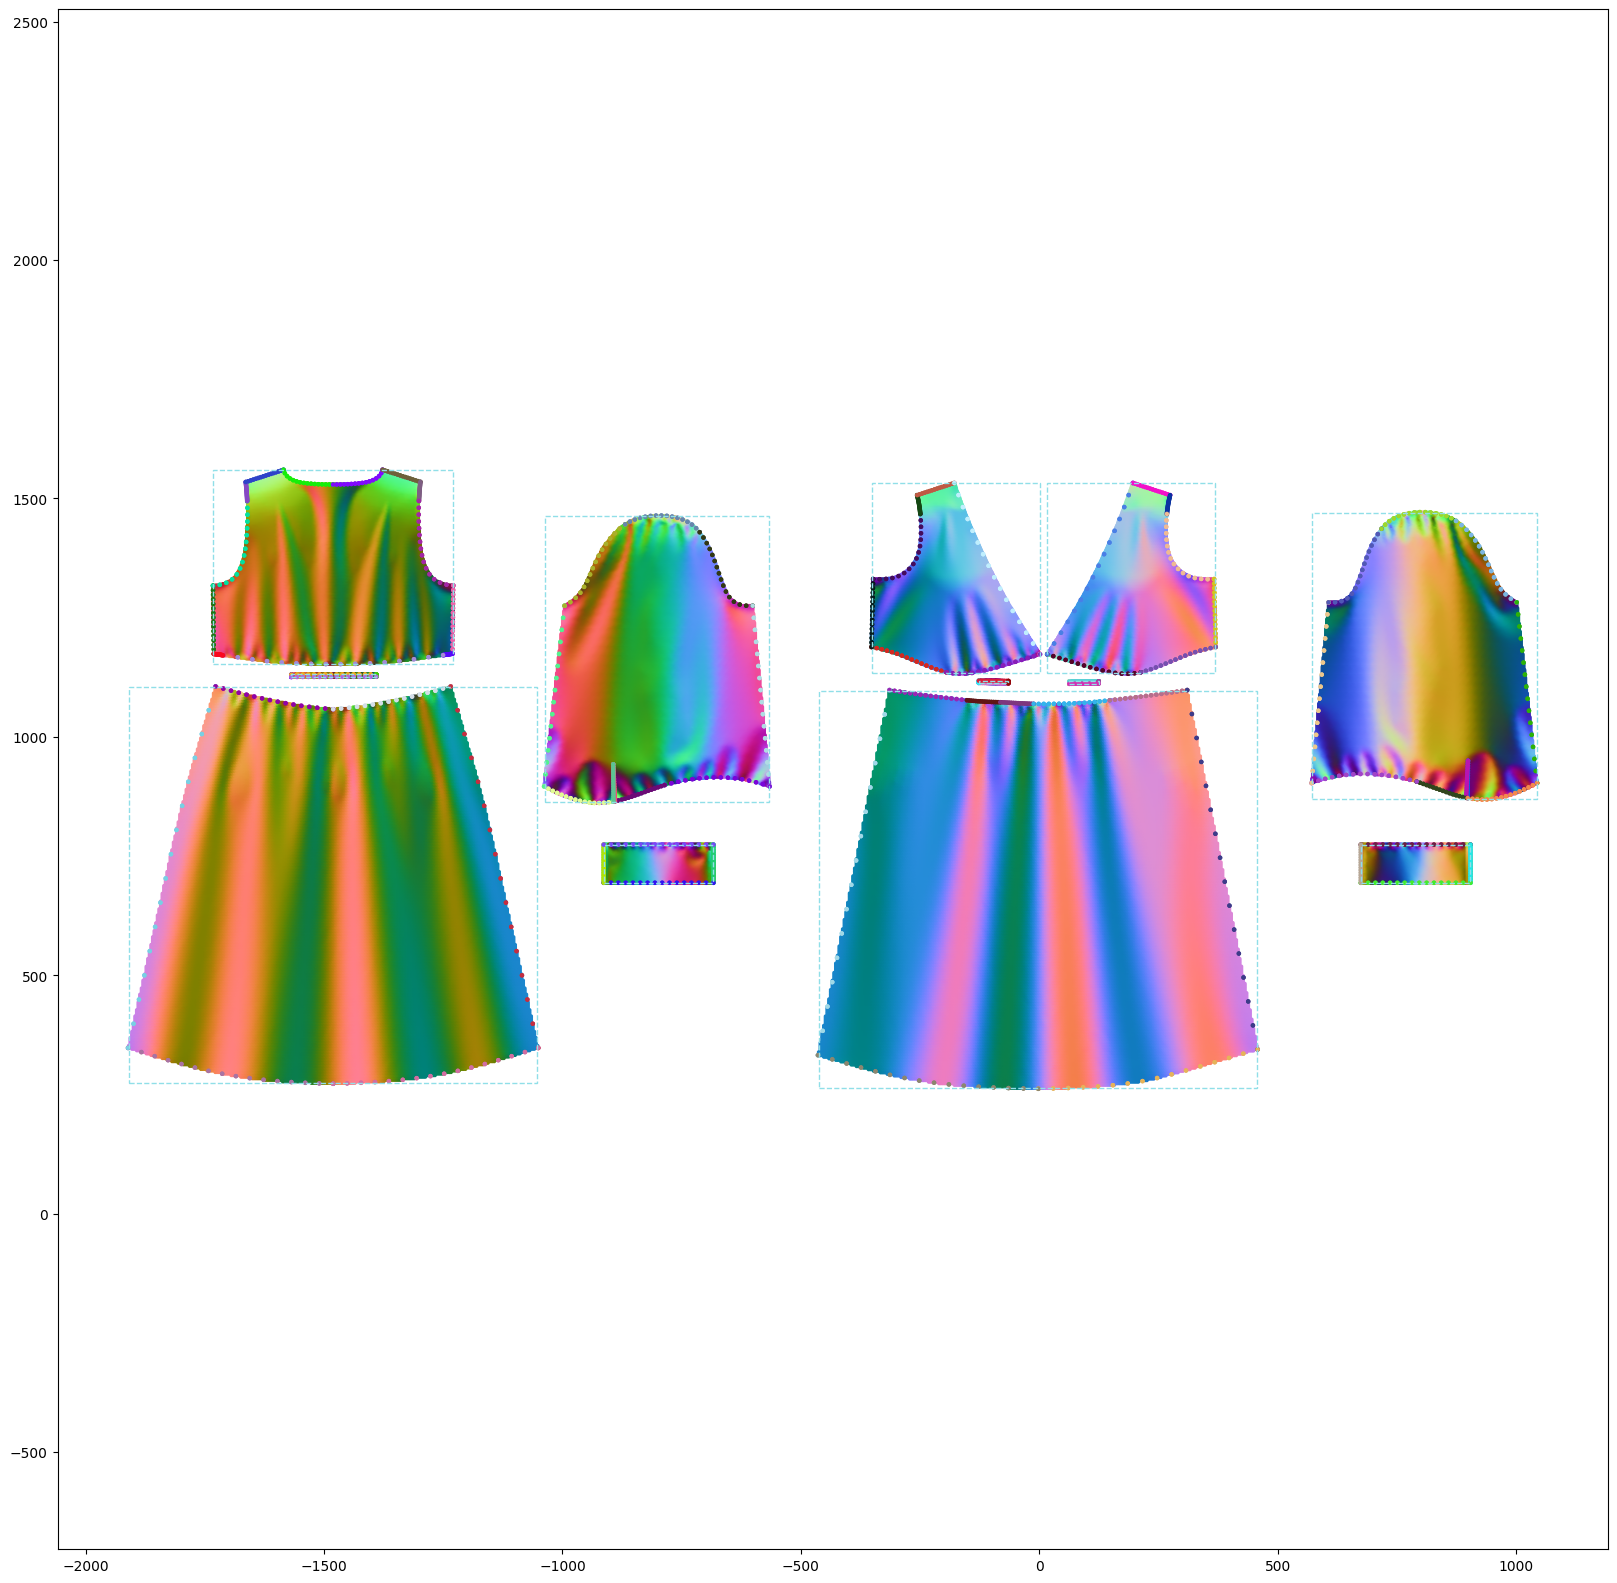

In [2]:
import os
import random
import pickle
import open3d as o3d

import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches 
from matplotlib.colors import to_rgb


from glob import glob

_CMAP = {
    "帽": {"alias": "帽", "color": "#F7815D"},
    "领": {"alias": "领", "color": "#F9D26D"},
    "肩": {"alias": "肩", "color": "#F23434"},
    "袖片": {"alias": "袖片", "color": "#C4DBBE"},
    "袖口": {"alias": "袖口", "color": "#F0EDA8"},
    "衣身前中": {"alias": "衣身前中", "color": "#8CA740"},
    "衣身后中": {"alias": "衣身后中", "color": "#4087A7"},
    "衣身侧": {"alias": "衣身侧", "color": "#DF7D7E"},
    "底摆": {"alias": "底摆", "color": "#DACBBD"},
    "腰头": {"alias": "腰头", "color": "#DABDD1"},
    "裙前中": {"alias": "裙前中", "color": "#46B974"},
    "裙后中": {"alias": "裙后中", "color": "#6B68F5"},
    "裙侧": {"alias": "裙侧", "color": "#D37F50"},

    "橡筋": {"alias": "橡筋", "color": "#696969"},
    "木耳边": {"alias": "木耳边", "color": "#696969"},
    "袖笼拼条": {"alias": "袖笼拼条", "color": "#696969"},
    "荷叶边": {"alias": "荷叶边", "color": "#696969"
            
            },
    "绑带": {"alias": "绑带", "color": "#696969"}
}

_PANEL_CLS = [
    '帽', '领', '肩', '袖片', '袖口', '衣身前中', '衣身后中', '衣身侧', '底摆', '腰头', '裙前中', '裙后中', '裙侧', '橡筋', '木耳边', '袖笼拼条', '荷叶边', '绑带']


def _to_o3d_pc(xyz: np.ndarray, color=None):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(xyz)
    
    print('[_to_o3d_pc] color: ', pcd.points)
        
    if color is not None:
        if len(color) != len(xyz): 
            color = np.array(color)[None].repeat(len(xyz), axis=0)
        pcd.colors = o3d.utility.Vector3dVector(color)

    return pcd

def _draw_bboxes_2d(ax, bboxes_min, bboxes_max, color='r'):
    
    num_points = bboxes_min.shape[0]
    print(bboxes_min.shape, bboxes_max.shape, num_points)
    
    for idx in range(num_points):
        p0_ = bboxes_min[idx]
        p1_ = bboxes_max[idx]
        
        # Extract coordinates
        x0, y0 = p0_
        x1, y1 = p1_
        
        # Calculate width and height of the bounding box
        
        width = x1 - x0
        height = y1 - y0
        
        # Create a rectangle patch
        rect = patches.Rectangle(
            (x0, y0), width, height, linestyle='--', linewidth=1, 
            edgecolor=color, 
            facecolor='none')
        
        # Add the rectangle to the plot
        ax.add_patch(rect)
        
    
data_root = "E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep_reso_256\\"
data_path = random.choice(glob(os.path.join(data_root, '*.pkl')))
# data_path = os.path.join(data_root, '7529.pkl')

with open(data_path, "rb") as tf: data = pickle.load(tf)

print([x for x in data['faceEdge_adj'].items()])

print(data['data_fp'], data['surf_cls'])
print(data['surf_wcs'].shape, data['global_offset'], data['global_scale'])
print(data['edge_wcs'].shape, data['edge_uv_wcs'].shape)
print('*** ncs: ', data['surf_ncs'].shape, data['surf_ncs'].min(), data['surf_ncs'].max())

print('*** edge_bbox', data['edge_bbox_wcs'].shape, data['edge_uv_bbox_wcs'].shape, data['edge_ncs'].shape, data['edge_uv_ncs'].shape)

global_offset = np.array(data['global_offset'])[None]
global_scale = data['global_scale']

uv_offset = data['uv_offset'][None]
uv_scale = data['uv_scale']

########## CHECK WCS ###########
# surf_pnts = data['surf_mask'].reshape(-1, 1) * (data['surf_wcs'].reshape(-1, 3) * (global_scale * 0.5) + global_offset)
# edge_pnts = data['edge_wcs'].reshape(-1, 3) * (global_scale * 0.5) + global_offset
# surf_uvs = data['surf_mask'].reshape(-1, 1) * (data['surf_uv_wcs'].reshape(-1, 2) * (uv_scale * 0.5) + uv_offset)
# edge_uvs = data['edge_uv_wcs'].reshape(-1, 2) * (uv_scale * 0.5) + uv_offset
################################

########## CHECK NCS ###########
# Surface
bbox_scale = np.max(data['surf_bbox_wcs'][:, 3:] - data['surf_bbox_wcs'][:,:3], axis=1)[:, None, None, None]
bbox_offset = ((data['surf_bbox_wcs'][:, 3:] + data['surf_bbox_wcs'][:, :3]) * 0.5)[:, None, None, :]
surf_pnts_wcs = data['surf_mask'] * (data['surf_ncs'] * (bbox_scale * 0.5) + bbox_offset)
surf_pnts = data['surf_mask'].reshape(-1, 1) * (surf_pnts_wcs.reshape(-1, 3) * (global_scale * 0.5) + global_offset)

bbox_scale_uv = np.max(data['surf_uv_bbox_wcs'][:, 2:] - data['surf_uv_bbox_wcs'][:,:2], axis=1)[:, None, None, None]
bbox_offset_uv = ((data['surf_uv_bbox_wcs'][:, 2:] + data['surf_uv_bbox_wcs'][:, :2]) * 0.5)[:, None, None, :]
surf_uvs_wcs = data['surf_mask'] * (data['surf_uv_ncs'] * (bbox_scale_uv * 0.5) + bbox_offset_uv)
surf_uvs = data['surf_mask'].reshape(-1, 1) * (surf_uvs_wcs.reshape(-1, 2) * (uv_scale * 0.5) + uv_offset)
surf_masks = data['surf_mask'].reshape(-1).astype(bool)

# Edge
bbox_scale = np.max(data['edge_bbox_wcs'][:, 3:] - data['edge_bbox_wcs'][:,:3], axis=1)[:, None, None]
bbox_offset = ((data['edge_bbox_wcs'][:, 3:] + data['edge_bbox_wcs'][:, :3]) * 0.5)[:, None, :]
edge_pnts_wcs = data['edge_ncs'] * (bbox_scale * 0.5) + bbox_offset
edge_pnts = edge_pnts_wcs.reshape(-1, 3) * (global_scale * 0.5) + global_offset

bbox_scale_uv = np.max(data['edge_uv_bbox_wcs'][:, 2:] - data['edge_uv_bbox_wcs'][:,:2], axis=1)[:, None, None]
bbox_offset_uv = ((data['edge_uv_bbox_wcs'][:, 2:] + data['edge_uv_bbox_wcs'][:, :2]) * 0.5)[:, None, :]
edge_uvs_wcs = data['edge_uv_ncs'] * (bbox_scale_uv * 0.5) + bbox_offset_uv
edge_uvs = edge_uvs_wcs.reshape(-1, 2) * (uv_scale * 0.5) + uv_offset
################################

print('*** surf_pnts: ', surf_pnts.max(axis=0), surf_pnts.min(axis=0))
print('*** edge_pnts: ', edge_pnts.max(axis=0), edge_pnts.min(axis=0))
print('*** uv_offset: ', uv_offset.shape, uv_offset.max(axis=0), uv_offset.min(axis=0))


surf_colors = ((data['surf_normals'].reshape(-1, 3) + 1.0) * 0.5).clip(0, 1)
edge_colors = np.expand_dims(np.random.rand(data['edge_uv_wcs'].shape[0], 3), axis=1).repeat(data['edge_uv_wcs'].shape[1], axis=1).reshape(-1, 3)

surf_pcd = _to_o3d_pc(surf_pnts[surf_masks, :], surf_colors[surf_masks, :])
edge_pcd = _to_o3d_pc(edge_pnts, edge_colors)

fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax.scatter(surf_uvs[surf_masks, 0], surf_uvs[surf_masks, 1], c=surf_colors[surf_masks, :], s=3.5)
ax.scatter(edge_uvs[:, 0], edge_uvs[:, 1], c=edge_colors, s=5)
ax.scatter(edge_uvs[:, 0], edge_uvs[:, 1], c=edge_colors, s=5)

surf_uv_bbox_min = data['surf_uv_bbox_wcs'][:, :2] * (uv_scale * 0.5) + uv_offset
surf_uv_bbox_max = data['surf_uv_bbox_wcs'][:, 2:] * (uv_scale * 0.5) + uv_offset
surf_color = np.random.rand(len(surf_uv_bbox_min), 3)
print('*** surf_color: ', surf_uv_bbox_max.shape, surf_color.shape)
_draw_bboxes_2d(ax, surf_uv_bbox_min, surf_uv_bbox_max, color=np.random.rand(3))

print('*** edge uv bbox: ', data['edge_uv_bbox_wcs'].shape)
edge_uv_bbox_min = data['edge_uv_bbox_wcs'][:, :2] * (uv_scale * 0.5) + uv_offset
edge_uv_bbox_max = data['edge_uv_bbox_wcs'][:, 2:] * (uv_scale * 0.5) + uv_offset
# _draw_bboxes_2d(ax, edge_uv_bbox_min, edge_uv_bbox_max, color=surf_color)

# plt.axis('off')
plt.axis('equal')
plt.show()

surf_bboxes_3d = []
surf_bbox_min = data['surf_bbox_wcs'][:, :3] * (global_scale * 0.5) + global_offset
surf_bbox_max = data['surf_bbox_wcs'][:, 3:] * (global_scale * 0.5) + global_offset
for idx in range(surf_bbox_min.shape[0]):
    surf_bboxes_3d.append(o3d.geometry.AxisAlignedBoundingBox(surf_bbox_min[idx][..., None], surf_bbox_max[idx][..., None]))
    surf_bboxes_3d[-1].color = to_rgb(_CMAP[_PANEL_CLS[data['surf_cls'][idx]-1]]['color'])

mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1.0, origin=[0., 0., 0.])
o3d.visualization.draw_geometries([surf_pcd, edge_pcd, mesh_frame] + surf_bboxes_3d)

## Visualize Surface Points (check mask)

In [ ]:
import os
import numpy as np
import pickle
import random
from glob import glob
from matplotlib import pyplot as plt
import math

plt.rcParams['font.sans-serif']=['SimHei'] # Show Chinese label
plt.rcParams['axes.unicode_minus']=False   # These two lines need to be set manually

_PANEL_CLS = [
    '帽', '领', '肩', '袖片', '袖口', '衣身前中', '衣身后中', '衣身侧', '底摆', '腰头', '裙前中', '裙后中', '裙侧', '橡筋', '木耳边', '袖笼拼条', '荷叶边', '绑带']
    
data_root = "E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep_uni_norm\\"
data_path = random.choice(glob(os.path.join(data_root, '*.pkl')))

with open(data_path, "rb") as tf: data = pickle.load(tf)

print(data['data_fp'])

num_panels = data['surf_wcs'].shape[0]

n_cols = 8
n_rows = math.ceil(num_panels / n_cols)
print(num_panels, n_cols, n_rows)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 20/n_cols*n_rows))

for idx in range(num_panels):   
    # img_arr = data['surf_wcs'][idx]
    img_arr = data['surf_mask'][idx] * (data['surf_wcs'][idx] + 1.0) * 0.5
    x_idx = idx // n_cols
    y_idx = idx % n_cols     
    axs[x_idx, y_idx].set_title(_PANEL_CLS[data['surf_cls'][idx]-1])
    axs[x_idx, y_idx].imshow(np.clip(img_arr[::-1, :, :], 0., 1.).astype(np.float32))

plt.show()

## Visualize 2D Bounding Boxes

In [ ]:
import os
import random
import pickle
import open3d as o3d
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches 
from matplotlib.colors import to_rgb

from glob import glob

_CMAP = {
    "帽": {"alias": "帽", "color": "#F7815D"},
    "领": {"alias": "领", "color": "#F9D26D"},
    "肩": {"alias": "肩", "color": "#F23434"},
    "袖片": {"alias": "袖片", "color": "#C4DBBE"},
    "袖口": {"alias": "袖口", "color": "#F0EDA8"},
    "衣身前中": {"alias": "衣身前中", "color": "#8CA740"},
    "衣身后中": {"alias": "衣身后中", "color": "#4087A7"},
    "衣身侧": {"alias": "衣身侧", "color": "#DF7D7E"},
    "底摆": {"alias": "底摆", "color": "#DACBBD"},
    "腰头": {"alias": "腰头", "color": "#DABDD1"},
    "裙前中": {"alias": "裙前中", "color": "#46B974"},
    "裙后中": {"alias": "裙后中", "color": "#6B68F5"},
    "裙侧": {"alias": "裙侧", "color": "#D37F50"},

    "橡筋": {"alias": "橡筋", "color": "#DACBBD"},
    "木耳边": {"alias": "木耳边", "color": "#A8D4D2"},
    "袖笼拼条": {"alias": "袖笼拼条", "color": "#DACBBD"},
    "荷叶边": {"alias": "荷叶边", "color": "#A8D4D2"},
    "绑带": {"alias": "绑带", "color": "#696969"}
}

_PANEL_CLS = [
    '帽', '领', '肩', '袖片', '袖口', '衣身前中', '衣身后中', '衣身侧', '底摆', '腰头', '裙前中', '裙后中', '裙侧', '橡筋', '木耳边', '袖笼拼条', '荷叶边', '绑带']

def _draw_bboxes_2d(ax, bboxes_min, bboxes_max, color='r', cmap=None):
    num_points = bboxes_min.shape[0]
    for idx in range(num_points):
        p0_ = bboxes_min[idx]
        p1_ = bboxes_max[idx]
        
        # Extract coordinates
        
        x0, y0 = p0_
        x1, y1 = p1_
        
        # Calculate width and height of the bounding box
        width = x1 - x0
        height = y1 - y0
        # Create a rectangle patch
        rect = patches.Rectangle(
            (x0, y0), width, height, linestyle='--', linewidth=1, 
            edgecolor=color if cmap is None else cmap[idx], facecolor='none')
        # Add the rectangle to the plot
        ax.add_patch(rect)
        

data_root = "E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep_uni_norm\\"
all_items = random.choices(glob(os.path.join(data_root, '*.pkl')), k=100)

print('*** all_items: ', len(all_items), all_items)

surf_uv_bboxes = []

fig, ax = plt.subplots(1, 1, figsize=(20, 20))

x_min, y_min, x_max, y_max = np.inf, np.inf, -np.inf, -np.inf

for data_item in all_items:
    with open(data_item, "rb") as tf: data = pickle.load(tf)
    
    uv_scale = data['uv_scale']
    uv_offset = data['uv_offset']
    
    # print(uv_scale, uv_offset)
    
    # surf_uv_bbox_min = data['surf_uv_bbox_wcs'][:, :2]
    # surf_uv_bbox_max = data['surf_uv_bbox_wcs'][:, 2:]

    surf_uv_bbox_min = data['surf_uv_bbox_wcs'][:, :2] * uv_scale * 0.5 + uv_offset
    surf_uv_bbox_max = data['surf_uv_bbox_wcs'][:, 2:] * uv_scale * 0.5 + uv_offset
    
    if surf_uv_bbox_max[0].max() > x_max: x_max = surf_uv_bbox_max[0].max()
    if surf_uv_bbox_max[1].max() > y_max: y_max = surf_uv_bbox_max[1].max()
    if surf_uv_bbox_min[0].min() < x_min: x_min = surf_uv_bbox_min[0].min()
    if surf_uv_bbox_min[1].min() < y_min: y_min = surf_uv_bbox_min[1].min()
    
    surf_color = np.asarray([to_rgb(_CMAP[_PANEL_CLS[x-1]]['color']) for x in data['surf_cls']])
    _draw_bboxes_2d(ax, surf_uv_bbox_min, surf_uv_bbox_max, cmap=surf_color)    

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

plt.show()

## Visualize Bounding Box 3D

In [ ]:
import os
import random
import pickle
import open3d as o3d
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches 

from glob import glob

_CMAP = {
    "帽": {"alias": "帽", "color": "#F7815D"},
    "领": {"alias": "领", "color": "#F9D26D"},
    "肩": {"alias": "肩", "color": "#F23434"},
    "袖片": {"alias": "袖片", "color": "#C4DBBE"},
    "袖口": {"alias": "袖口", "color": "#F0EDA8"},
    "衣身前中": {"alias": "衣身前中", "color": "#8CA740"},
    "衣身后中": {"alias": "衣身后中", "color": "#4087A7"},
    "衣身侧": {"alias": "衣身侧", "color": "#DF7D7E"},
    "底摆": {"alias": "底摆", "color": "#DACBBD"},
    "腰头": {"alias": "腰头", "color": "#DABDD1"},
    "裙前中": {"alias": "裙前中", "color": "#46B974"},
    "裙后中": {"alias": "裙后中", "color": "#6B68F5"},
    "裙侧": {"alias": "裙侧", "color": "#D37F50"},

    "橡筋": {"alias": "橡筋", "color": "#DACBBD"},
    "木耳边": {"alias": "木耳边", "color": "#A8D4D2"},
    "袖笼拼条": {"alias": "袖笼拼条", "color": "#DACBBD"},
    "荷叶边": {"alias": "荷叶边", "color": "#A8D4D2"},
    "绑带": {"alias": "绑带", "color": "#696969"}
}

_PANEL_CLS = [
    '帽', '领', '肩', '袖片', '袖口', '衣身前中', '衣身后中', '衣身侧', '底摆', '腰头', '裙前中', '裙后中', '裙侧', '橡筋', '木耳边', '袖笼拼条', '荷叶边', '绑带'
    ]
        

data_root = "E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep_uni_norm\\"
all_items = random.choices(glob(os.path.join(data_root, '*.pkl')), k=100)

print('*** all_items: ', len(all_items), all_items)

surf_bboxes = []

for data_item in all_items:
    with open(data_item, "rb") as tf: data = pickle.load(tf)
    
    global_scale = data['global_scale']
    global_offset = data['global_offset']
    
    
    # print(uv_scale, uv_offset)
    
    surf_bbox_min = data['surf_bbox_wcs'][:, :3]
    surf_bbox_max = data['surf_bbox_wcs'][:, 3:]
    
    # surf_bbox_min = data['surf_bbox_wcs'][:, :3] * global_scale * 0.5 + global_offset
    # surf_bbox_max = data['surf_bbox_wcs'][:, 3:] * global_scale * 0.5 + global_offset
    
    for idx in range(surf_bbox_min.shape[0]):
        surf_bbox = o3d.geometry.AxisAlignedBoundingBox(surf_bbox_min[idx][..., None], surf_bbox_max[idx][..., None])
        surf_bbox.color = to_rgb(_CMAP[_PANEL_CLS[data['surf_cls'][idx]-1]]['color'])
        surf_bboxes.append(surf_bbox)

mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1.0, origin=[0., 0., 0.])
o3d.visualization.draw_geometries([mesh_frame] + surf_bboxes)

## Test extract polygon from surf UV points

In [ ]:
import os
import random
import pickle
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial import ConvexHull

import torch
import torch.nn.functional as F

from shapely.geometry import MultiPoint, Polygon
from shapely.ops import unary_union, polygonize
from scipy.spatial import Delaunay

import open3d as o3d

from skimage import measure
from skimage.feature import corner_harris, corner_subpix, corner_peaks

from glob import glob

_PAD_SIZE = 1


def _to_o3d_pc(xyz: np.ndarray, color=None):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(xyz)        
    if color is not None:
        if len(color) != len(xyz): 
            color = np.array(color)[None].repeat(len(xyz), axis=0)
        pcd.colors = o3d.utility.Vector3dVector(color)

    return pcd


def calculate_curvature(points, shift=1.0):
    vec1 = points - np.roll(points, shift, axis=0)
    vec2 = np.roll(points, -shift, axis=0) - points
    
    vec1 = vec1 / (np.linalg.norm(vec1, axis=1)[:, None] + 1e-6)
    vec2 = vec2 / (np.linalg.norm(vec2, axis=1)[:, None] + 1e-6)
    
    angles = np.arccos(np.sum(vec1 * vec2, axis=-1))      
    angles = angles / np.pi * 180
    
    return angles


def snap_coordinate(points, conf_mat):
    coord_x = points[:, 0]
    coord_y = points[:, 1]

    right = np.ceil(coord_x).astype(int)
    left = np.floor(coord_x).astype(int)
    top = np.ceil(coord_y).astype(int)
    bottom = np.floor(coord_y).astype(int)

    corner_conf_mat = np.stack([
        conf_mat[bottom, left], 
        conf_mat[bottom, right], 
        conf_mat[top, left], 
        conf_mat[top, right]], 
        axis=-1)

# data_root = "/data/lry/data/AIGP/demo_v2/Q2/brep_uni_norm"
# data_path = random.choice(glob(os.path.join(data_root, '*.pkl')))
# data_path = os.path.join(data_root, '1975.pkl')

data_path = 'test.pkl'

with open(data_path, "rb") as tf: data = pickle.load(tf)

print(data.keys())

data['surf_mask'] = data['new_surf_mask']
data['surf_uv_wcs'] = data['new_surf_uv_wcs']

uv_offset = data['uv_offset'][None]
uv_scale = data['uv_scale']

edge_3d_pts = []
corner_3d_pts = []

# fig, ax = plt.subplots(figsize=(20, 20))

for panel_idx in range(data['surf_uv_wcs'].shape[0]):
        
    cur_mask = data['surf_mask'][panel_idx, :, :, 0].astype(float)
    print('*** cur_mask: ', cur_mask.shape, cur_mask.min(), cur_mask.max())

    cur_mask = F.sigmoid(torch.tensor(cur_mask)).numpy()
    print('*** cur_mask_prob: ', cur_mask.shape, cur_mask.min(), cur_mask.max())
    
    panel_color = np.random.rand(3)
    
    H, W = data['surf_mask'].shape[1:3]
    print(H, W)

    # Find contours at a constant value of 0.5
    padded_mask = np.zeros((cur_mask.shape[0] + 2 * _PAD_SIZE, cur_mask.shape[1] + 2 * _PAD_SIZE))
    padded_mask[_PAD_SIZE:-_PAD_SIZE, _PAD_SIZE:-_PAD_SIZE] = cur_mask
    
    contours = measure.find_contours(padded_mask, 0.999)[0]
    corner_coords = corner_peaks(corner_harris(padded_mask), min_distance=3, threshold_rel=0.01)

    corner_contour_dist = np.linalg.norm(corner_coords[:, None] - contours[None], axis=-1)
    corner_contour_idx = np.argmin(corner_contour_dist, axis=1)
    
    print('*** contours: ', contours.shape, contours.min(axis=0), contours.max(axis=0))
    boundary_index = np.round(contours-_PAD_SIZE).astype(int)
    corner_index = boundary_index[corner_contour_idx, :]
        
    boundary_index[:, 0] = np.clip(boundary_index[:, 0] + _PAD_SIZE, 0, H-1+2*_PAD_SIZE)
    boundary_index[:, 1] = np.clip(boundary_index[:, 1] + _PAD_SIZE, 0, W-1+2*_PAD_SIZE)
    corner_index[:, 0] = np.clip(corner_index[:, 0], 0, H-1+2*_PAD_SIZE)
    corner_index[:, 1] = np.clip(corner_index[:, 1], 0, W-1+2*_PAD_SIZE)

    fig, ax = plt.subplots(figsize=(10, 10))
    plt.imshow(padded_mask, cmap='gray')
    ax.plot(contours[:, 1], contours[:, 0], linewidth=2)
    ax.scatter(boundary_index[:, 1], boundary_index[:, 0], s=5.0, c='r')
        
    ax.plot(
        corner_coords[:, 1], corner_coords[:, 0], color='cyan', marker='o', linestyle='None', markersize=15
    )
    
    ax.axis('image')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()
        
    # break
    
#     # Extract 2D coordinate of boundary points
#     cur_panel_uvs = data['surf_uv_wcs'][panel_idx]
#     boundary_uvs = cur_panel_uvs[boundary_index[:, 0], boundary_index[:, 1]]
#     boundary_uvs = boundary_uvs * (uv_scale * 0.5) + uv_offset
#     ax.plot(boundary_uvs[:, 0], boundary_uvs[:, 1], linewidth=2, c=panel_color)

#     corner_uvs = cur_panel_uvs[corner_index[:, 0], corner_index[:, 1]]
#     corner_uvs = corner_uvs * (uv_scale * 0.5) + uv_offset
#     ax.scatter(corner_uvs[:, 0], corner_uvs[:, 1], c='r', s=20)
            
#     cur_panel_pts = data['surf_wcs'][panel_idx]
#     boundary_pts = cur_panel_pts[boundary_index[:, 0].astype(int), boundary_index[:, 1].astype(int)]
#     boundary_pts = boundary_pts * (data['global_scale'] * 0.5) + data['global_offset']
#     boundary_pts = _to_o3d_pc(boundary_pts, color=panel_color)
#     edge_3d_pts.append(boundary_pts)
    
#     corner_pts = cur_panel_pts[corner_index[:, 0], corner_index[:, 1]]
#     corner_pts = corner_pts * (data['global_scale'] * 0.5) + data['global_offset']
#     if corner_pts.shape[0] > 0:
#         corner_pts = _to_o3d_pc(corner_pts, color=np.array([1., 0., 0.]))
#         corner_3d_pts.append(corner_pts)

# ax.axis('equal')
# ax.axis('off')
# plt.show()

# mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1.0, origin=[0., 0., 0.])
# o3d.visualization.draw_geometries([mesh_frame] + edge_3d_pts + corner_3d_pts)

# Validate Panel Data




In [ ]:

import os
import json
from glob import glob
from tqdm import tqdm
import numpy as np
import shutil

from matplotlib import pyplot as plt

_MAX_NUM_PANELS = 32
_MAX_NUM_EDGES = 40

data_roots = [
    "\\\\192.168.29.222\\Share\\工程数据Q1\\objs", 
    "\\\\192.168.29.222\\Share\\工程数据Q2_objs"
    ]
all_items = []

print(">>> Locating data items...")
for data_root in data_roots:
    cur_items = glob(os.path.join(data_root, '**', 'pattern.json'), recursive=True)
    all_items += cur_items
    print("%d items in %s."%(len(cur_items), data_root))

num_panels = []
num_edges = []
    
invalid_other = []
invalid_wrong_panel_name = []
invalid_too_many_edges = []
invalid_too_many_panels = []
    
_PANEL_CLS = [
    '帽', '领', '肩', '袖片', '袖口', '衣身前中', '衣身后中', '衣身侧', '底摆', '腰头', '裙前中', '裙后中', '裙侧', '橡筋', '木耳边', '袖笼拼条', '荷叶边', '绑带']
    
print(">>> Validating data items...")
for data_fp in tqdm(all_items):
    try:        
        with open(data_fp, 'r', encoding='utf-8') as f: pattern_spec = json.load(f)
        n_panels = len(pattern_spec['panels'])
        if n_panels > _MAX_NUM_PANELS:
            invalid_too_many_panels.append((data_fp, n_panels))
            print('[TOO_MANY_PANELS] %s: %d'%(data_fp, n_panels))
        
        num_panels.append(n_panels)
        for panel in pattern_spec['panels']:
            if panel['label'].strip().split()[0].split('_')[0] not in _PANEL_CLS:
                invalid_wrong_panel_name.append((data_fp, panel['id'], panel['label']))
                print('\t [WRONG_PANEL_LABEL] %s: %s - %s'%(data_fp, panel['id'], panel['label']))
            n_edges = sum([len(x['edges']) for x in panel['seqEdges'] if x['type'] == 3])
            if n_edges > _MAX_NUM_EDGES:
                invalid_too_many_edges.append((data_fp, panel['id'], n_edges))
                print('\t [TOO_MANY_EDGES] %s: %s - %d'%(data_fp, panel['id'], n_edges))
            num_edges.append(n_edges)
        
    except Exception as e:
        invalid_other.append(data_fp)
        print('Error in %s: %s'%(data_fp, e))
        continue
            
print('>>> Summary: ')
print('\t num_panels: min=%d; max=%d;, avg=%.4f'%(min(num_panels), max(num_panels), np.mean(num_panels)))
print('\t num_edges: min=%d; max=%d;, avg=%.4f'%(min(num_edges), max(num_edges), np.mean(num_edges)))

plt.hist(np.asarray(num_panels), bins=range(0, 100, 1))
plt.show()

plt.hist(np.asarray(num_edges), bins=range(0, 50, 1))
plt.show()

# # move invalid items to seperate folder
# print(">>> Moving invalid items to seperate directory...")
# invalid_items_total = invalid_other + [x[0] for x in invalid_wrong_panel_name] + [x[0] for x in invalid_too_many_edges] + [x[0] for x in invalid_too_many_panels]
# invalid_items_total = set([os.path.dirname(x) for x in invalid_items_total])
# for src_item in tqdm(invalid_items_total):
#     dst_item = src_item.replace("objs", "invalid")
#     os.makedirs(os.path.dirname(dst_item), exist_ok=True)
#     try:
#         shutil.move(src_item, dst_item)
#     except Exception as e:
#         print("\t Failed to move %s to %s"%(src_item, dst_item))


# ############## Logging to file ##############
# log_fp = "error_log.txt"
# print(">>> Logging invalid items to %s..."%(log_fp))
# with open(log_fp, 'w') as f:
#     f.write(">>> INVALID: \n")
#     for item in invalid_other:
#         f.write("\t %s\n"%os.path.dirname(item).replace('工程数据Q1\objs', '工程数据Q1\sprojs').replace('工程数据Q2_objs', '工程数据Q2'))
#     f.write("\n")
#     f.write(">>> WRONG_PANEL_LABEL: \n")
#     for item in invalid_wrong_panel_name:
#         f.write("\t %s\n"%os.path.dirname(item[0]).replace('工程数据Q1\objs', '工程数据Q1\sprojs').replace('工程数据Q2_objs', '工程数据Q2'))
#     f.write(">>> TOO_MANY_EDGES: \n")
#     for item in invalid_too_many_edges:
#         f.write("\t %s \t (edge_id: %s, num_edges: %d)\n"%(
#             os.path.dirname(item[0]).replace('工程数据Q1\objs', '工程数据Q1\sprojs').replace('工程数据Q2_objs', '工程数据Q2'),
#             item[1], item[2]
#             ))
#     f.write(">>> TOO_MANY_PANELS: \n")
#     for item in invalid_too_many_panels:
#         f.write("\t %s \t (num_panels: %d)\n"%(os.path.dirname(item[0]).replace('工程数据Q1\objs', '工程数据Q1\sprojs').replace('工程数据Q2_objs', '工程数据Q2'), item[1]))

In [ ]:
# convert obj to point cloud
import os
import sys

import json

from glob import glob
from tqdm import tqdm

import numpy as np

sys.path.insert(0, os.path.abspath('..'))

from data_process.geometry_utils.obj import read_obj
from matplotlib.colors import to_rgb

_CMAP = {
    "帽": {"alias": "hat", "color": "#F7815D"},
    "领": {"alias": "collar", "color": "#F9D26D"},
    "肩": {"alias": "shoulder", "color": "#F23434"},
    "袖片": {"alias": "sleeve", "color": "#C4DBBE"},
    "袖口": {"alias": "cuff", "color": "#F0EDA8"},
    "衣身前中": {"alias": "body front", "color": "#8CA740"},
    "衣身后中": {"alias": "body back", "color": "#4087A7"},
    "衣身侧": {"alias": "body side", "color": "#DF7D7E"},
    "底摆": {"alias": "hem", "color": "#DACBBD"},
    "腰头": {"alias": "belt", "color": "#DABDD1"},
    
    "裙前中": {"alias": "skirt front", "color": "#46B974"},
    "裙后中": {"alias": "skirt back", "color": "#6B68F5"},
    "裙侧": {"alias": "skirt side", "color": "#D37F50"},
    
    "裤前中": {"alias": "pelvis front", "color": "#46B974"},
    "裤后中": {"alias": "pelvis back", "color": "#6B68F5"},
    "裤侧": {"alias": "pelvis side", "color": "#D37F50"},

    "橡筋": {"alias":"ruffles", "color": "#A8D4D2"},
    "木耳边": {"alias":"ruffles", "color": "#A8D4D2"},
    "袖笼拼条": {"alias":"ruffles", "color": "#A8D4D2"},
    "荷叶边": {"alias":"ruffles", "color": "#A8D4D2"},
    "绑带": {"alias":"ruffles", "color": "#A8D4D2"}
}

_GLOBAL_SCALE = 1000.0


data_roots = [
    "\\\\192.168.29.222\\Share\\工程数据Q1\\objs", 
    "\\\\192.168.29.222\\Share\\工程数据Q2_objs"
    ]
all_items = []

print(">>> Locating data items...")
for data_root in data_roots:
    cur_items = glob(os.path.join(data_root, '**', 'pattern.json'), recursive=True)
    all_items += cur_items
    print("%d items in %s."%(len(cur_items), data_root))
    
print(len(all_items))

pc_output_root = "E:\\lry\\data\\AIGP\\demo_v2\\Q2\\pointclouds"
all_data_dirs = [os.path.dirname(x) for x in all_items]

for idx, data_dir in enumerate(all_data_dirs):
    output_dir = os.path.join(pc_output_root, 'garment_%05d'%idx)
    os.makedirs(output_dir, exist_ok=True)
    
    obj_fp = os.path.join(data_dir, os.path.basename(data_dir)+'.obj')
    pattern_fp = os.path.join(data_dir, 'pattern.json')
    
    with open(pattern_fp, 'r', encoding='utf-8') as f: pattern_spec = json.load(f)
    
    out_panel_names = dict([(
        x['id'], 
        _CMAP[x['label'].split('|')[0].strip()]['alias'].replace(' ', '')+'_'+x['id'].split('-')[0]) \
        for x in pattern_spec['panels']])
    
    out_panel_names_sorted = {}
    for out_item in sorted(out_panel_names.values()):
        panel_cls, panel_id = out_item.split('_')
        if panel_cls not in out_panel_names_sorted: out_panel_names_sorted[panel_cls] = []
        out_panel_names_sorted[panel_cls].append(panel_id)
        
    for out_item in out_panel_names:
        panel_cls, panel_id = out_panel_names[out_item].split('_')
        panel_idx = out_panel_names_sorted[panel_cls].index(panel_id)
        out_panel_names[out_item] = '%s_%d'%(panel_cls, panel_idx+1)
        
    mesh_obj = read_obj(obj_fp)
    
    verts = mesh_obj.points
    normals = mesh_obj.point_data['obj:vn']
    uv = mesh_obj.point_data['obj:vt']
    
    for idx, panel_id in enumerate(mesh_obj.field_data['obj:group_tags']):
        if panel_id not in out_panel_names: continue
        
        panel_faces = mesh_obj.cells[idx].data        
        panel_verts_idx = np.unique(panel_faces.flatten())
        
        panel_verts = verts[panel_verts_idx, :] / _GLOBAL_SCALE
        panel_normals = normals[panel_verts_idx, :]
        panel_uvs = uv[panel_verts_idx, :2] / _GLOBAL_SCALE     # global uv
        
        panel_output = np.concatenate([panel_verts, panel_normals, panel_uvs], axis=1)
        panel_out_fp = os.path.join(output_dir, out_panel_names[panel_id]+'.txt')
    
        with open(panel_out_fp, 'w') as f:
            f.writelines('# x y z nx ny nz u v\n')
            np.savetxt(f, panel_output, fmt='%.6f')

In [ ]:
# visualize point cloud

import os

import numpy as np

import open3d as o3d
from matplotlib.colors import to_rgb

_CMAP = {
    "帽": {"alias": "hat", "color": "#F7815D"},
    "领": {"alias": "collar", "color": "#F9D26D"},
    "肩": {"alias": "shoulder", "color": "#F23434"},
    "袖片": {"alias": "sleeve", "color": "#C4DBBE"},
    "袖口": {"alias": "cuff", "color": "#F0EDA8"},
    "衣身前中": {"alias": "body front", "color": "#8CA740"},
    "衣身后中": {"alias": "body back", "color": "#4087A7"},
    "衣身侧": {"alias": "body side", "color": "#DF7D7E"},
    "底摆": {"alias": "hem", "color": "#DACBBD"},
    "腰头": {"alias": "belt", "color": "#DABDD1"},
    
    "裙前中": {"alias": "skirt front", "color": "#46B974"},
    "裙后中": {"alias": "skirt back", "color": "#6B68F5"},
    "裙侧": {"alias": "skirt side", "color": "#D37F50"},
    
    "裤前中": {"alias": "pelvis front", "color": "#46B974"},
    "裤后中": {"alias": "pelvis back", "color": "#6B68F5"},
    "裤侧": {"alias": "pelvis side", "color": "#D37F50"},

    "橡筋": {"alias":"ruffles", "color": "#A8D4D2"},
    "木耳边": {"alias":"ruffles", "color": "#A8D4D2"},
    "袖笼拼条": {"alias":"ruffles", "color": "#A8D4D2"},
    "荷叶边": {"alias":"ruffles", "color": "#A8D4D2"},
    "绑带": {"alias":"ruffles", "color": "#A8D4D2"}
}


_CMAP = dict([(_CMAP[x]['alias'].replace(' ', ''), to_rgb(_CMAP[x]['color'])) for x in _CMAP])
print(_CMAP)

def _to_o3d_pc(xyz: np.ndarray, color=None):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(xyz)
    
    print('[_to_o3d_pc] color: ', pcd.points)
        
    if color is not None:
        if len(color) != len(xyz): 
            color = np.array(color)[None].repeat(len(xyz), axis=0)
        pcd.colors = o3d.utility.Vector3dVector(color)

    return pcd

data_dir = "E:\\lry\\data\\AIGP\\demo_v2\\Q2\\pointclouds\\garment_00000"

panel_points = []
for panel_fp in os.listdir(data_dir):
    panel_cls = panel_fp.split('_')[0]
    panel_color = _CMAP[panel_cls]
    
    panel_pts = np.loadtxt(os.path.join(data_dir, panel_fp))
    panel_points.append(_to_o3d_pc(panel_pts[:, :3], color=panel_color))

o3d.visualization.draw_geometries(panel_points)

# Test SDF pattern (&& Countor Finding)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import measure


# Construct some test data
x, y = np.ogrid[-np.pi : np.pi : 100j, -np.pi : np.pi : 100j]
r = np.sin(np.exp(np.sin(x) ** 3 + np.cos(y) ** 2))

print(r.shape, r.max(), r.min())    # (-1.0, 1.0)

# Find contours at a constant value of 0.8
contours = measure.find_contours(r, 0.8)

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(r, cmap=plt.cm.gray)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [ ]:
import numpy as np

def calculate_curvature(points):
    vec1 = points - np.roll(points, 1, axis=0)
    vec2 = np.roll(points, -1, axis=0) - points
    
    vec1 = vec1 / np.linalg.norm(vec1, axis=1)[:, None]
    vec2 = vec2 / np.linalg.norm(vec2, axis=1)[:, None]
    
    angles = np.arccos(np.sum(vec1 * vec2, axis=-1))      
    angles = angles / np.pi * 180
    
    return angles

pts = np.array([[0, 0], [1, 1], [2, 1], [3, 0], [1.5, -1.5]])
angles = calculate_curvature(pts)
print(angles)
print(np.where(angles > 75))

# Test render vertice class labels.

In [ ]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'


import sys
import random
from glob import glob

import json

import numpy as np
import torch
import nvdiffrast.torch as dr

PROJ_ROOT = os.path.abspath('..')
sys.path.insert(0, PROJ_ROOT)
sys.path.insert(0, os.path.join(PROJ_ROOT, 'data_process'))

from geometry_utils.obj import read_obj
from process_sxd import _get_vert_cls, _interpolate_feature_dr
from matplotlib import pyplot as plt

_RESO = 256

_POINT_CMAP = np.array([
    [0., 0., 0.],       # 0: background points
    [0.33, 0.33, 0.33], # 1: surface points
    [1.0, 0., 0.],      # 2: edge points 
    [0., 1., 0.]        # 3: corner points
])

data_roots = "\\\\192.168.29.222\\Share\\工程数据Q1\\objs"
all_objs = glob(os.path.join(data_roots, '**', '*.obj'), recursive=True)
print('Total items: ', len(all_objs))

data_fp = os.path.dirname(random.choice(all_objs))

mesh_obj = read_obj(os.path.join(data_fp, os.path.basename(data_fp)+'.obj'))
with open(os.path.join(data_fp, 'pattern.json'), 'r', encoding='utf-8') as f: pattern_spec = json.load(f)

vert_cls = _get_vert_cls(mesh_obj, pattern_spec)
print(mesh_obj.point_data['obj:cls'].shape, vert_cls.shape, vert_cls.dtype)
print(mesh_obj.point_data['obj:cls'][:10])

# verts = mesh_obj.points
# uv = mesh_obj.point_data['obj:vt']

# print('*** verts: ', verts.shape, uv.shape, vert_cls.shape)

# ############# test get_cls [OK] #############

# fig = plt.figure(figsize=(20, 20))
# interior_pts_uv = uv[vert_cls==1, :]
# # print("*** interior_pts_uv: ", interior_pts_uv.shape, type(interior_pts_uv))
# plt.scatter(interior_pts_uv[:, 0], interior_pts_uv[:, 1], c='grey', s=1.0)
# edge_pts_uv = uv[vert_cls==2, :]
# plt.scatter(edge_pts_uv[:, 0], edge_pts_uv[:, 1], c='r', s=5.0)
# corner_pts_uv = uv[vert_cls==3, :]
# plt.scatter(corner_pts_uv[:, 0], corner_pts_uv[:, 1], c='g', s=5.0)

# plt.axis('off')
# plt.show()

############# test rendering #################
glctx = dr.RasterizeCudaContext()

verts = torch.from_numpy(mesh_obj.points).to(torch.float32).to('cuda')
uv = torch.from_numpy(mesh_obj.point_data['obj:vt']).to(torch.float32).to('cuda')
normals = torch.from_numpy(mesh_obj.point_data['obj:vn']).to(torch.float32).to('cuda')
vert_cls = torch.from_numpy(mesh_obj.point_data['obj:cls']).to(torch.float32).to('cuda')

panel_data = dict([(x['id'], x) for x in pattern_spec['panels']])

panel_ids = []
panel_cls = []

uv_local = uv.clone()               # projected pixel coordinate for each vertex

tris = []                           # all triangles
tri_ranges = []                     # triangle range for each panel,
start_idx = 0

for idx, panel_idx in enumerate(mesh_obj.field_data['obj:group_tags']):    
    
    panel_faces = mesh_obj.cells[idx].data
    panel_verts_idx = np.unique(panel_faces.flatten())
    
    tris.append(torch.from_numpy(panel_faces).to('cuda'))
    tri_ranges.append([start_idx, len(panel_faces)])
    start_idx += len(panel_faces)
    
    panel_bbox2d = torch.cat([
        torch.min(uv_local[panel_verts_idx, :], dim=0, keepdim=True)[0],
        torch.max(uv_local[panel_verts_idx, :], dim=0, keepdim=True)[0]
    ])

    uv_local[panel_verts_idx, :] = (uv_local[panel_verts_idx, :] - panel_bbox2d[0]) / (
        panel_bbox2d[1] - panel_bbox2d[0] + 1e-6)      # normalize to [0, 1]
    
tris = torch.cat(tris, dim=0).to(torch.int32)
tri_ranges = torch.tensor(tri_ranges, dtype=torch.int32)
print('*** tri_ranges: ', tri_ranges.shape)   

uv_local = uv_local[..., :2] * 2.0 - 1.0
uv_local = torch.cat([
    uv_local,
    torch.zeros_like(uv_local[:, :1]),
    torch.ones_like(uv_local[:, :1])], dim=1)

rast, _ = dr.rasterize(
    glctx, uv_local, tris, 
    resolution=[_RESO, _RESO], 
    ranges=tri_ranges)

surf_pnts = _interpolate_feature_dr(rast, uv_local, tris, verts)
surf_cls = _interpolate_feature_dr(rast, uv_local, tris, vert_cls[:, None] * 40, antialias=True).astype(np.int32)

print(surf_pnts.shape, surf_cls.shape, surf_pnts.min(), surf_pnts.max(), surf_cls.min(), surf_cls.max())
    
for surf_idx in range(surf_cls.shape[0]):
    plt.imshow(surf_pnts[surf_idx])
    # colored_surf_cls = _POINT_CMAP[surf_cls[surf_idx].flatten(), :].reshape(_RESO, _RESO, 3)
    # plt.imshow(colored_surf_cls)
    plt.show()
    break


# Test meshing

## Grid Triangulation

In [ ]:
import os
import pickle

import numpy as np
import scipy
import einops
import skimage

import open3d as o3d


def _pad_arr(arr, pad_size=10):
    return np.pad(
        arr, 
        ((pad_size, pad_size), (pad_size, pad_size), (0, 0)),   # pad size to each dimension, require tensor to have size (H,W, C)
        mode='constant', 
        constant_values=0)

def _to_o3d_mesh(verts: np.ndarray, faces: np.ndarray, color=None):
    verts = o3d.utility.Vector3dVector(verts)
    faces = o3d.utility.Vector3iVector(faces)
    mesh = o3d.geometry.TriangleMesh(verts, faces)
        
    if color is not None:
        if len(color) != len(verts): 
            color = np.array(color)[None].repeat(len(verts), axis=0)
        mesh.vertex_colors = o3d.utility.Vector3dVector(color)   
        
    return mesh


def _to_o3d_pc(xyz: np.ndarray, color=None):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(xyz)
    
    print('[_to_o3d_pc] color: ', pcd.points)
        
    if color is not None:
        if len(color) != len(xyz): 
            color = np.array(color)[None].repeat(len(xyz), axis=0)
        pcd.colors = o3d.utility.Vector3dVector(color)

    return pcd


def _make_grid(bb_min=[0,0,0], bb_max=[1,1,1], shape=[10,10,10], 
            mode='on', flatten=True, indexing="ij"):
    """ Make a grid of coordinates

    Args:
        bb_min (list or np.array): least coordinate for each dimension
        bb_max (list or np.array): maximum coordinate for each dimension
        shape (list or int): list of coordinate number along each dimension. If it is an int, the number
                            same for all dimensions
        mode (str, optional): 'on' to have vertices lying on the boundary and 
                              'in' for keeping vertices and its cell inside of the boundary
                              same as align_corners=True and align_corners=False
        flatten (bool, optional): Return as list of points or as a grid. Defaults to True.
        indexing (["ij" or "xy"]): default to "xy", see https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html

    Returns:
        np.array: return coordinates (XxYxZxD if flatten==False, X*Y*ZxD if flatten==True.
    """    
    coords=[]
    bb_min = np.array(bb_min)
    bb_max = np.array(bb_max)
    if type(shape) is int:
        shape = np.array([shape]*bb_min.shape[0])
    for i,si in enumerate(shape):
        if mode=='on':
            coord = np.linspace(bb_min[i], bb_max[i], si)
        elif mode=='in':
            offset = (bb_max[i]-bb_min[i])/2./si
            # 2*si*w=bmax-bmin
            # w = (bmax-bmin)/2/si
            # start, end = bmax+w, bmin-w
            coord = np.linspace(bb_min[i]+offset,bb_max[i]-offset, si)
        coords.append( coord )
    grid = np.stack(np.meshgrid(*coords,sparse=False, indexing=indexing), axis=-1)
    if flatten==True:
        grid = grid.reshape(-1,grid.shape[-1])
    return grid


def _prune_unused_vertices(vert, face):
    # Identify all unique vertex indices used in face
    unique_vert_ind = np.unique(face)
    mapper = np.zeros(vert.shape[0], dtype=int)
    mapper[unique_vert_ind] = np.arange(unique_vert_ind.shape[0])
    new_face = mapper[face]
    # Create the new vertices array using only the used vertices
    new_vert = vert[unique_vert_ind]
    
    return new_vert, new_face, unique_vert_ind


def _downsample_sparse_pooling(omg, factor=4, anti_aliasing=False, visualize=False):
    """ downsample input array with sparse pooling
    Args:
        omg: np.ndarray, (H, W, 4), omage tensor
        factor: int, downsample factor
        anti_aliasing: bool, whether to use anti_aliasing
        visualize: bool, whether to visualize the result
    Returns:
        dict, containing 'omg_down_star', 'omg_down', 'sov', 'edge_occ_down'
        'omg_down_star': np.ndarray, downsampled omg with edge snapping
        'omg_down': np.ndarray, downsampled omg without edge snapping
        'sov': np.ndarray, occupancy map with snapped boundaries highlighted
        'edge_occ_down': np.ndarray, edge occupancy map
    """
    # assuming omg is 1024 x 1024
    occ = omg[..., 3]>=.5
    eroded_mask = scipy.ndimage.binary_erosion(occ, structure=np.ones((3,3))) # sqaure strucure is needed to get the corners
    edge_occ = ~eroded_mask & occ
    edge_omg = omg.copy()
    edge_omg[edge_occ==0] = -1.
    
    edge_occ_patches = einops.rearrange(edge_occ, '(h1 h2) (w1 w2) -> h1 w1 h2 w2', h2=factor, w2=factor)
    edge_occ_down = edge_occ_patches.max(axis=-1).max(axis=-1)
    eod_0_count  = (edge_occ_patches==0).sum(axis=-1).sum(axis=-1)
    eod_1_count  = (edge_occ_patches==1).sum(axis=-1).sum(axis=-1)
    edge_omg_patches = einops.rearrange(edge_omg, '(h1 h2) (w1 w2) c-> h1 w1 h2 w2 c', h2=factor, w2=factor)
    edge_omg_down = edge_omg_patches.sum(axis=-2).sum(axis=-2) + eod_0_count[...,None]
    edge_omg_down = np.divide(edge_omg_down, eod_1_count[...,None], out=np.zeros_like(edge_omg_down), where=eod_1_count[...,None]!=0)

    omg_down = skimage.transform.resize(omg, (omg.shape[0]//factor,)*2, order=0, preserve_range=False, anti_aliasing=anti_aliasing)
    
    omg_down_star = edge_omg_down * (edge_occ_down[...,None]) + omg_down * (1-edge_occ_down[...,None])
    star_occ = (omg_down[...,3] >= .5) | edge_occ_down
    
    sov = (omg_down[...,3] >= .5) # for visualizaton
    sov = sov * .5 + edge_occ_down.astype(float)
    sov[sov>=1.] = 1.

    return dict(omg_down_star=omg_down_star, omg_down=omg_down,
            sov=sov, edge_occ_down=edge_occ_down, edge_occ=edge_occ)


def meshing_uv_map(occupancy):
    occ = occupancy.astype(bool)
    pixel_index = np.arange(occ.size).reshape(occ.shape)

    # Determine triangles' vertices
    is_tri_vert = occ & np.roll(occ, shift=-1, axis=0) & np.roll(occ, shift=-1, axis=1)
    verta = pixel_index
    vertb = np.roll(pixel_index, shift=-1, axis=1)
    vertc = np.roll(pixel_index, shift=-1, axis=0)
    face0 = np.stack([verta[is_tri_vert], vertb[is_tri_vert], vertc[is_tri_vert]], axis=1)
    
    # Determine the second set of triangles' vertices
    is_tri_vert = occ & np.roll(occ, shift=1, axis=0) & np.roll(occ, shift=1, axis=1)
    verta = pixel_index
    vertb = np.roll(pixel_index, shift=1, axis=1)
    vertc = np.roll(pixel_index, shift=1, axis=0)
    face1 = np.stack([verta[is_tri_vert], vertb[is_tri_vert], vertc[is_tri_vert]], axis=1)
    
    # Combine the two sets of faces
    face = np.concatenate([face0, face1], axis=0)

    return face


def grid_triangulation(
    occ, vert, 
    normal=None, 
    color=None, 
    prune_verts=True, 
    return_o3d_mesh=False,
    return_boundary_verts=False):
    """ Turn an omage into a mesh.
    Args:
        occ: np.ndarray of shape (H, W, 1) representing the occupancy map.
        vert: np.ndarray of shape (H, W, 3) representing the 3D position of each vertex.
        normal: np.ndarray of shape (H, W, 3) representing the normal.
        return_uv: bool, whether to return uv as well.
        prune_verts: bool, whether to remove unused vertices to reduce size.
    """    
    occ = _pad_arr(occ)
    vert = _pad_arr(vert)
    normal = _pad_arr(normal) if normal is not None else None
    
    # Generate pixel indices array
    vert         = vert.reshape(-1, 3)
    normal       = normal.reshape(-1, 3) if normal is not None else None
    
    face = meshing_uv_map(occ)
    if face.shape[0] == 0: # no face, return empty mesh
        meshing_ret = dict( vert = np.zeros((0,3)), face = np.zeros((0,3)).astype(int), uv = np.zeros((0,2)))
        return meshing_ret

    # flip faces with inconsistent objnormal vs face normal
    if normal is not None:
        face_normal = np.cross(vert[face[:,1]] - vert[face[:,0]], vert[face[:,2]] - vert[face[:,0]])
        flip_mask = np.einsum('ij,ij->i', face_normal, normal[face[:,0]]) < 0
        face[flip_mask] = face[flip_mask][:,[0,2,1]]
    
    uv = _make_grid([0,0], [1,1], shape=(occ.shape[0], occ.shape[1]), mode='on')
    uv[..., [0,1]] = uv[..., [1,0]] # swap x, y to match the image coordinate system
    
    
    # TODO: snap
    
    
    meshing_ret=dict( vert=vert, face=face, uv=uv)

    if prune_verts:
        vert, face, unique_vert_ind = _prune_unused_vertices(vert, face)
        uv = uv[unique_vert_ind]
        for key in meshing_ret:
            if key not in ['vert', 'face', 'uv']:
                print(key, meshing_ret[key].shape)
                meshing_ret[key] = meshing_ret[key][unique_vert_ind]
        meshing_ret['vert'], meshing_ret['face'], meshing_ret['uv'] = vert, face, uv
        if color is not None:
            meshing_ret['color'] = color[unique_vert_ind]
        
    if return_o3d_mesh:
        return _to_o3d_mesh(
            meshing_ret['vert'], 
            meshing_ret['face'], 
            color=color if color is not None else np.random.rand(3))
        
    if return_boundary_verts: pass
        
    return meshing_ret


# data_dir = "E:\\lry\\code\\style3d_gen\\resources\\examples\\outputs_2"
data_dir = "E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep_uni_norm"

for idx in range(1,6):
    
    with open(os.path.join(data_dir, '%04d.pkl'%(idx)), 'rb') as f: data = pickle.load(f)
    position = data['surf_wcs']
    occ = data['surf_mask']
    
    # with open(os.path.join(data_dir, 'position', 'xyz_%d.pkl'%(idx)), 'rb') as f: position = pickle.load(f)
    # with open(os.path.join(data_dir, 'occ', 'mask_%d.pkl'%(idx)), 'rb') as f: occ = pickle.load(f)
    # occ = occ[:, 0, :, :][..., None] 
    # print('*** occ: ', occ.shape, occ.min(), occ.max(), occ.mean())

    meshes = []
    boundary_verts = []

    for s_idx in range(position.shape[0]):        
        # OPTION 1 : grid triangulation        
        mesh_ret = grid_triangulation(
            occ[s_idx] > 0.85,
            position[s_idx][..., :3],
            return_o3d_mesh=True
        )
        meshes.append(mesh_ret)
        
        # # OPTION 2: del triangulation
        # coords = np.argwhere(occ[s_idx] > 0.85)
        # plt.imshow(occ[s_idx], cmap='gray')
        # plt.scatter(coords[:, 1], coords[:, 0])
        # print(coords.shape, coords[0])
        # break
        
        # print("*** ", s_idx, mesh_ret['vert'].shape, mesh_ret['vert'].dtype, mesh_ret['face'].shape,  mesh_ret['face'].dtype)
        # meshes.append(mesh_ret)
        # verts = o3d.utility.Vector3dVector(mesh_ret['vert'])
        # faces = o3d.utility.Vector3iVector(mesh_ret['face'])
        # meshes.append(_to_o3d_mesh(mesh_ret['vert'], mesh_ret['face'], color=np.random.rand(3)))

    # for mesh in meshes:
    #     # calculate boundary facets
    #     pass

    # o3d.visualization.draw_geometries(meshes)
    o3d.visualization.draw_geometries(meshes, mesh_show_wireframe=True)
    break


## Delaunay Triangulation

In [ ]:
import os
import pickle

import numpy as np
import numpy.typing as npt

from scipy.spatial import Delaunay
from skimage import measure
from matplotlib import pyplot as plt

from shapely import geometry

def _pad_arr(arr, pad_size=5):
    return np.pad(arr, ((pad_size, pad_size), (pad_size, pad_size), (0, 0)), mode='constant', constant_values=0)


def _to_o3d_mesh(verts: np.ndarray, faces: np.ndarray, color=None):
    verts = o3d.utility.Vector3dVector(verts)
    faces = o3d.utility.Vector3iVector(faces)
    mesh = o3d.geometry.TriangleMesh(verts, faces)
        
    if color is not None:
        if len(color) != len(verts): 
            color = np.array(color)[None].repeat(len(verts), axis=0)
        mesh.vertex_colors = o3d.utility.Vector3dVector(color)   
        
    return mesh

def _bilinear_interpolate(feat, x, y):
    # Get integer and fractional parts of the coordinates
    x0 = np.floor(x).astype(int)
    x1 = x0 + 1
    y0 = np.floor(y).astype(int)
    y1 = y0 + 1

    # Ensure coordinates are within image bounds
    x0 = np.clip(x0, 0, feat.shape[1] - 1)
    x1 = np.clip(x1, 0, feat.shape[1] - 1)
    y0 = np.clip(y0, 0, feat.shape[0] - 1)
    y1 = np.clip(y1, 0, feat.shape[0] - 1)

    # Calculate the interpolation weights
    wa = (x1 - x) * (y1 - y)
    wb = (x1 - x) * (y - y0)
    wc = (x - x0) * (y1 - y)
    wd = (x - x0) * (y - y0)

    # Get the values at the four surrounding pixels
    Ia = feat[y0, x0]
    Ib = feat[y1, x0]
    Ic = feat[y0, x1]
    Id = feat[y1, x1]

    # Compute the interpolated value
    return wa[:, None] * Ia + wb[:, None] * Ib + wc[:, None] * Ic + wd[:, None] * Id


data_dir = "E:\\lry\\code\\style3d_gen\\resources\\examples\\outputs_2"
for idx in range(1, 6):
    
    # fig, axs = plt.subplots(1, 3, figsize=(30, 10))
    
    print("\nLoading data %d..."%(idx))
    
    with open(os.path.join(data_dir, 'position', 'xyz_%d.pkl'%(idx)), 'rb') as f: position = pickle.load(f)
    print('*** position: ', position.shape, position.min(), position.max())

    with open(os.path.join(data_dir, 'occ', 'mask_%d.pkl'%(idx)), 'rb') as f: occ = pickle.load(f)
    occ = occ[:, 0, :, :][..., None]
    print('*** occupancy: ', occ.shape, occ.min(), occ.max(), occ.mean(), occ[np.random.randint(0, occ.shape[0]), 0, :, :].shape)

    with open(os.path.join(data_dir, 'uv', 'uv_%d.pkl'%(idx)), 'rb') as f: uv = pickle.load(f)
    print('*** uv: ', uv.shape, uv.min(), uv.max())

    valid_idx = np.where(occ > 0.5)
    print(len(valid_idx), valid_idx[0].shape, valid_idx[1].shape)
    
    mesh3ds = []
    
    for s_idx in range(position.shape[0]):
        cur_occ = _pad_arr(occ[s_idx])[..., 0]
        cur_pos = _pad_arr(position[s_idx])[..., :3]
        
        # print('cur_occ: ', cur_occ.shape, cur_occ.min(), cur_occ.max(), cur_occ.mean())
        contours = measure.find_contours(cur_occ, 0.5)
        if len(contours) > 1:
            print(f'{len(contours)} separate polygons found in mask. Using largest.')
            contours.sort(key=len, reverse=True)
        
        # plt.imshow(cur_occ, cmap=plt.cm.grey)
        # for contour in contours: plt.plot(contour[:, 1], contour[:, 0], linewidth=2)
        
        outside_vertices: npt.NDArray[np.float64] = measure.approximate_polygon(contours[0], tolerance=0.1)
        
        outline = geometry.Polygon(contours[0])
        
        # add some internal vertices to ensure a good mesh is created
        inside_vertices_xy = []
        _x = np.linspace(0, cur_occ.shape[0], 32)
        _y = np.linspace(0, cur_occ.shape[0], 32)
        xv, yv = np.meshgrid(_x, _y)
        
        coords = np.stack([xv.flatten(), yv.flatten()], axis=1)
        grid_occ_val = _bilinear_interpolate(cur_occ[..., None], coords[:, 1], coords[:, 0])
        
        for idx, (x, y) in enumerate(coords):
            if outline.contains(geometry.Point(x, y)) and grid_occ_val[idx] > 0.85:
                inside_vertices_xy.append((x, y))
        
        # for x, y in zip(xv.flatten(), yv.flatten()):
        #     if outline.contains(geometry.Point(x, y)) and cur_occ[int(x), int(y)] > 0.5:
        #         inside_vertices_xy.append((x, y))
        inside_vertices: npt.NDArray[np.float64] = np.array(inside_vertices_xy)
        
        # plt.scatter(outside_vertices[:, 1], outside_vertices[:, 0], c='g', s=1.5)

        vertices: npt.NDArray[np.float32] = np.concatenate([outside_vertices, inside_vertices]).astype(np.float32)

        """
        Create a convex hull containing the character.
        Then remove unnecessary edges by discarding triangles whose centroid
        falls outside the character's outline.
        """
        convex_hull_triangles = Delaunay(vertices)
        triangles = []
        for _triangle in convex_hull_triangles.simplices:
            tri_vertices = np.array(
                [vertices[_triangle[0]], vertices[_triangle[1]], vertices[_triangle[2]]])
            tri_centroid = geometry.Point(np.mean(tri_vertices, 0))
            if outline.contains(tri_centroid):
                triangles.append(_triangle)

        # print('*** vertices: ', vertices.shape, vertices.min(), vertices.max())
        # plt.scatter(vertices[:, 1], vertices[:, 0], c='r', s=0.5)

        vertices_3d = _bilinear_interpolate(cur_pos, vertices[:, 0], vertices[:, 1])
        
        cur_mesh = _to_o3d_mesh(vertices_3d, np.array(triangles), color=np.random.rand(3))
        mesh3ds.append(cur_mesh)
        
        # plt.show()
        
    o3d.visualization.draw_geometries(mesh3ds, mesh_show_wireframe=True)
    
    # padded_occ = _pad_arr(occ[np.random.randint(0, occ.shape[0]), 0, :, :][..., None], pad_size=10)
    # print('*** padded_occ: ', padded_occ.shape, padded_occ.min(), padded_occ.max(), padded_occ.mean())
    # plt.imshow(padded_occ)
    # plt.show()

    

# Test Render Boundary Facets

>>> Loading mesh:  \\192.168.29.222\Share\工程数据Q1\objs\仅工程类\0306\阙志华\合体一片袖交叉门襟木耳边连衣裙\合体一片袖交叉门襟木耳边连衣裙.obj
[SURF] boundary_verts_idx:  (300,)
[SURF] boundary_verts_idx:  (300,)
[SURF] boundary_verts_idx:  (245,)
[SURF] boundary_verts_idx:  (246,)
[SURF] boundary_verts_idx:  (366,)
[SURF] boundary_verts_idx:  (875,)
[SURF] boundary_verts_idx:  (729,)
[SURF] boundary_verts_idx:  (875,)
[SURF] boundary_verts_idx:  (729,)
[SURF] boundary_verts_idx:  (338,)
[SURF] boundary_verts_idx:  (338,)
[SURF] boundary_verts_idx:  (538,)
[SURF] boundary_verts_idx:  (131,)
[SURF] boundary_verts_idx:  (538,)
[SURF] boundary_verts_idx:  (138,)
[INTERPOLATE] out:  torch.Size([15, 256, 256, 3]) torch.Size([15, 256, 256, 4]) torch.Size([111946, 4]) torch.Size([217140, 3])
[INTERPOLATE] out:  torch.Size([15, 256, 256, 3]) torch.Size([15, 256, 256, 4]) torch.Size([111946, 4]) torch.Size([217140, 3])
[INTERPOLATE] out:  torch.Size([15, 256, 256, 3]) torch.Size([15, 256, 256, 4]) torch.Size([111946, 4]) torch.Size(

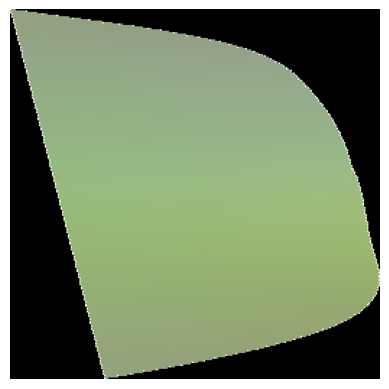

In [15]:
import os
import sys

import torch

import numpy as np

import json
import igl

from glob import glob
import random

from matplotlib import pyplot as plt

PROJ_ROOT = os.path.abspath('..')
sys.path.insert(0, PROJ_ROOT)
sys.path.insert(0, os.path.join(PROJ_ROOT, 'data_process'))

import nvdiffrast.torch as dr
from geometry_utils.obj import read_obj
from process_sxd import prepare_surf_data

def _pad_arr(arr, pad_size=5):
    return np.pad(arr, ((pad_size, pad_size), (pad_size, pad_size), (0, 0)), mode='constant', constant_values=0)

# data_roots = [
#     "\\\\192.168.29.222\\Share\\工程数据Q1\\objs", 
#     # "\\\\192.168.29.222\\Share\\工程数据Q2_objs"
#     ]
# all_items = []

# print(">>> Locating data items...")
# for data_root in data_roots:
#     cur_items = glob(os.path.join(data_root, '**', 'pattern.json'), recursive=True)
#     cur_items = [os.path.dirname(x) for x in cur_items]
#     all_items += cur_items
#     print("%d items in %s."%(len(cur_items), data_root))
# print('[DONE] locating data items, total %d items.'%(len(all_items)))
    
# data_fp = random.choice(all_items)
# print('>>> Randomly selected data item: ', data_fp)

_RESO = 256
_GLOBAL_SCALE = 2000.0
_GLOBAL_OFFSET = np.array([0.0, 1000.0, 0.0])

data_fp = "\\\\192.168.29.222\\Share\\工程数据Q1\\objs\\仅工程类\\0306\\阙志华\\合体一片袖交叉门襟木耳边连衣裙"
mesh_fp = os.path.join(data_fp, os.path.basename(data_fp)+'.obj')
pattern_fp = os.path.join(data_fp, 'pattern.json')

print('>>> Loading mesh: ', mesh_fp)
mesh_obj = read_obj(mesh_fp)
with open(pattern_fp, 'r', encoding='utf-8') as f: pattern_spec = json.load(f)

glctx = dr.RasterizeCudaContext()

panel_ids, panel_cls, surf_pnts, surf_uvs, surf_norms, surf_mask, boundary_verts, boundary_verts_uv = prepare_surf_data(
    glctx, mesh_obj, pattern_spec, reso=_RESO)

surf_pnts = (surf_pnts - _GLOBAL_OFFSET[None, None, None, :]) / (_GLOBAL_SCALE * 0.5)
surf_pnts = (surf_pnts + 1.0) * 0.5 * surf_mask
print(np.max(surf_pnts), np.min(surf_pnts))

for idx in range(len(panel_ids)):
    
    _surf_pnts = surf_pnts[idx]
    _bverts = boundary_verts[idx]
    _bverts_uv = boundary_verts_uv[idx]
    _bverts_uv = np.round(_bverts_uv * (_RESO-1)).astype(np.int32)
    
    _surf_pnts[_bverts_uv[:, 1], _bverts_uv[:, 0], :] = 1.0
    
    print(surf_pnts[idx].shape, surf_pnts.min(), surf_pnts.max())
    padded_pnts = surf_pnts[idx]
    print(surf_pnts[idx].shape, padded_pnts.shape)
    plt.imshow(padded_pnts)
    
    plt.axis('off')
    plt.show()
    
    break
    

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Helper function to project 3D points onto 2D
def project_vertices(vertices, image_size, projection_matrix=None):
    if projection_matrix is None:
        # If no projection matrix is provided, use an identity projection for simplicity
        projection_matrix = np.eye(3)
    
    # Project vertices
    projected = np.dot(vertices, projection_matrix.T)
    
    # Normalize the projection (perspective divide, if necessary)
    projected_2d = projected[:, :2] / np.maximum(1e-8, projected[:, 2].reshape(-1, 1))
    
    # Scale to fit image size
    projected_2d = projected_2d * np.array([image_size[1], image_size[0]]) / 2.0 + np.array([image_size[1] / 2, image_size[0] / 2])
    return projected_2d

# Helper function to identify boundary edges
def find_boundary_edges(faces):
    edge_dict = {}
    for tri in faces:
        edges = [(tri[0], tri[1]), (tri[1], tri[2]), (tri[2], tri[0])]
        for edge in edges:
            # Sort the edge so we can count undirected edges
            sorted_edge = tuple(sorted(edge))
            if sorted_edge in edge_dict:
                edge_dict[sorted_edge] += 1
            else:
                edge_dict[sorted_edge] = 1

    # Boundary edges are those that only appear once
    boundary_edges = [edge for edge, count in edge_dict.items() if count == 1]
    return boundary_edges

# Rasterization function using OpenCV
def rasterize_edges(image, vertices_2d, edges):
    for edge in edges:
        pt1 = tuple(vertices_2d[edge[0]].astype(int))
        pt2 = tuple(vertices_2d[edge[1]].astype(int))
        # Draw the edge on the image
        cv2.line(image, pt1, pt2, (255, 255, 255), 1)

# Example input data: a simple cube mesh
vertices = np.array([
    [-1, -1, -1],
    [ 1, -1, -1],
    [ 1,  1, -1],
    [-1,  1, -1],
    [-1, -1,  1],
    [ 1, -1,  1],
    [ 1,  1,  1],
    [-1,  1,  1]
])

faces = np.array([
    [0, 1, 2], [0, 2, 3],  # bottom face
    [4, 5, 6], [4, 6, 7],  # top face
    [0, 1, 5], [0, 4, 5],  # front face
    [1, 2, 6], [1, 5, 6],  # right face
    [2, 3, 7], [2, 6, 7],  # back face
    [3, 0, 4], [3, 4, 7]   # left face
])

# Image settings
image_size = (500, 500)

# Projection matrix (identity for simplicity, assumes orthographic projection)
projection_matrix = np.eye(3)

# Project the vertices to 2D
vertices_2d = project_vertices(vertices, image_size, projection_matrix)

# Find boundary edges
boundary_edges = find_boundary_edges(faces)

# Create an empty image
image = np.zeros((image_size[0], image_size[1], 3), dtype=np.uint8)

# Rasterize the boundary edges
rasterize_edges(image, vertices_2d, boundary_edges)

# Show the result
plt.imshow(image)
plt.axis('off')
plt.show()


# Test curve fitting

0d5980d1-3fb5-4aeb-8bf4-fea92dfd3c86 [1315.05834961 1708.6895752     0.        ]


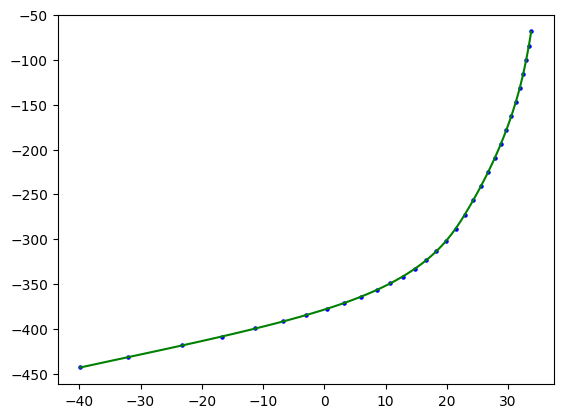

In [ ]:
import os
import json

import numpy as np
from geomdl import fitting, BSpline, utilities
from matplotlib import pyplot as plt

data_fp = "\\\\192.168.29.222\\Share\\工程数据Q1\\objs\\仅工程类\\0306\\阙志华\\合体一片袖交叉门襟木耳边连衣裙"
pattern_fp = os.path.join(data_fp, 'pattern.json')

with open(pattern_fp, 'r', encoding='utf-8') as f: pattern_spec = json.load(f)

for panel in pattern_spec['panels']:
    origin = np.array(panel['center'])
    print(panel['id'], origin)
    
    for seq_edge in panel['seqEdges']:
        for edge in seq_edge['edges']:
            # sampling along edge
            # print('\t ', edge['id'])
            
            bezierPts = np.asarray(edge['bezierPoints'])[:, :2]
            ctrlPts = np.asarray(edge['controlPoints'])[:, :2]

            if np.any(bezierPts) and len(ctrlPts) == 2:
                if not np.any(bezierPts[1]):
                    # print('quadratic bezier')
                    bezierPts[1] = 2.0 / 3.0 * \
                        (bezierPts[0] + ctrlPts[0] - ctrlPts[1])
                    bezierPts[0] = 2.0 / 3.0 * bezierPts[0]

                bezierPts = ctrlPts + bezierPts
                curve = BSpline.Curve()
                curve.degree = 3
                curve.ctrlpts = [ctrlPts[0].tolist()] + \
                    bezierPts.tolist() + [ctrlPts[1].tolist()]
                curve.knotvector = utilities.generate_knot_vector(
                    curve.degree, len(curve.ctrlpts))
                curve.sample_size = 100
                curve.evaluate()

                line_color = 'r'
                evalpts = np.array(curve.evalpts)

            else:
                if ctrlPts.shape[0] <= 2:
                    evalpts = ctrlPts
                else:
                    curve = fitting.interpolate_curve(
                        ctrlPts.tolist(), degree=2 if ctrlPts.shape[0] < 5 else 3)
                    curve.sample_size = 100
                    curve.evaluate()
                    evalpts = np.array(curve.evalpts)
                    line_color = 'g'
            
            plt.plot(evalpts[:, 0], evalpts[:, 1], c=line_color)
            plt.scatter(ctrlPts[:, 0], ctrlPts[:, 1], s=5.0, c='b')
            
            break
        break
    break
                    

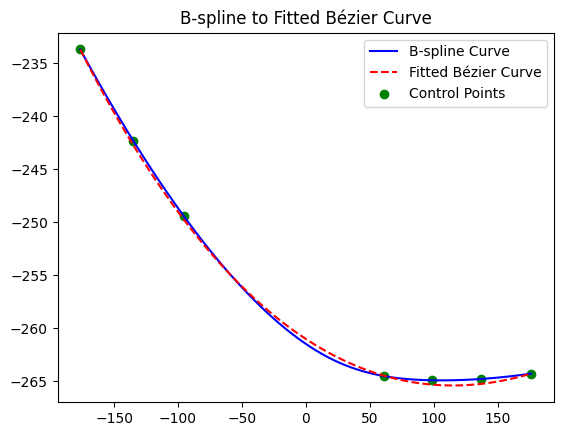

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from geomdl import fitting

def bezier_curve(t, P0, P1, P2, P3):
    return (1 - t)**3 * P0 + 3 * (1 - t)**2 * t * P1 + 3 * (1 - t) * t**2 * P2 + t**3 * P3

# 最小二乘拟合误差函数
def bezier_error(params, t_values, target_points):
    P1, P2 = params[:2], params[2:]  # 中间控制点
    bezier_pts = np.array([bezier_curve(t, target_points[0], P1, P2, target_points[-1]) for t in t_values])
    return np.ravel(bezier_pts - target_points)

# 从B样条曲线拟合贝塞尔曲线的函数
def fit_bezier_to_bspline(b_spline_curve, num_points=100):
    # 采样B样条曲线
    b_spline_curve.sample_size = num_points
    b_spline_curve.evaluate()
    b_spline_points = np.array(b_spline_curve.evalpts)

    # 取起点和终点
    P0 = b_spline_points[0]
    P3 = b_spline_points[-1]

    # 在[0, 1]范围内生成t值
    t_values = np.linspace(0, 1, num_points)

    # 初始猜测：简单取中间点作为初始猜测
    initial_guess = np.concatenate([b_spline_points[num_points // 3], b_spline_points[2 * num_points // 3]])

    # 使用最小二乘拟合贝塞尔控制点
    result = least_squares(bezier_error, initial_guess, args=(t_values, b_spline_points))

    # 拟合出的中间控制点
    P1, P2 = result.x[:2], result.x[2:]

    return P0, P1, P2, P3

# 示例B样条曲线的控制点
control_points = [
    [-176.42614746 ,-233.71960449], [-134.82684326, -242.35858154], [ -95.40942383 ,-249.44714355], [  61.31274414 ,-264.52349854], [  98.38586426 ,-264.91290283], [ 136.84790039 ,-264.79144287], [ 176.10986328 ,-264.28552246]]



# 使用插值函数生成B样条曲线
b_spline_curve = fitting.interpolate_curve(control_points, degree=3)

# 将B样条曲线转换为三次贝塞尔曲线
P0, P1, P2, P3 = fit_bezier_to_bspline(b_spline_curve)

# 生成贝塞尔曲线的点
t_values = np.linspace(0, 1, 100)
bezier_points = np.array([bezier_curve(t, P0, P1, P2, P3) for t in t_values])

# 绘制B样条曲线和拟合出的贝塞尔曲线
b_spline_curve.sample_size = 100
b_spline_curve.evaluate()
b_spline_points = np.array(b_spline_curve.evalpts)

plt.plot(b_spline_points[:, 0], b_spline_points[:, 1], 'b-', label='B-spline Curve')
plt.plot(bezier_points[:, 0], bezier_points[:, 1], 'r--', label='Fitted Bézier Curve')

control_points = np.array(control_points)
plt.scatter(control_points[:, 0], control_points[:, 1], c='g', label='Control Points')

plt.legend()
plt.title('B-spline to Fitted Bézier Curve')
plt.show()